In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import pearsonr


In [2]:

def rf(dataset):
    # Load dataset
    df = pd.read_csv(f'{dataset}_combined.csv')
    df = df[df['P'] > 1]
    if dataset == 'x70':
        df=df[(df['P']>1)]
        df=df[(df['P']<6)  | (df['P']>30)]
        
    X = df[['K','P']]
    y = df['dadN']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)
    
    param_grid = {
        'model__n_estimators': list(range(50, 100, 10)),
        'model__max_depth': [None] + list(range(5, 40, 5)),
        'model__min_samples_split': list(range(2, 11)),
        'model__min_samples_leaf': list(range(1, 6)), 
        'model__max_features': list(range(2, 20, 2)),
        'model__bootstrap': [True, False],
        'model__criterion': ['squared_error', 'absolute_error']
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=1))
    ])

    search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'],  
        refit='r2',
        n_jobs=-1, 
        return_train_score=True
    )
    
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Save the best model
    filename = f'{dataset}_p_{best_model.__class__.__name__}.pkl'
    joblib.dump(best_model, filename)

    # Test set predictions
    y_pred_test = best_model.predict(X_test)

    # Metrics on test set
    r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    mape = mean_absolute_percentage_error(y_test, y_pred_test)  # MAPE calculation
    mse = mean_squared_error(y_test, y_pred_test)  #
    r = pearsonr(y_test, y_pred_test)

    print(f"Best Parameters: {search.best_params_}")
    print(f'Optimized RF: R² = {r2:.4f}, MAE = {mae:.3e}, MSE = {mse:.3e}, MAPE = {mape:.3%}, Pearson r = {r[0]:.4f}')

    # Plot y_test vs. y_pred_test
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, y_test, 'r-', label='Ideal Line (y = y_test)')  # Straight line
    plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue', label='Predictions')  # Scatter predictions
    plt.xlabel("Actual (y_test)")
    plt.ylabel("Predicted")
    plt.title("y_test vs. Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()

        # Create a DataFrame with actual and predicted values
    resultz_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_test
    })

    # Save to CSV
    resultz_df.to_csv(f'{dataset}_rfz_predictions.csv', index=False)



In [3]:
# Function to load a saved model
def load_model(dataset, model_name):



    filename = f'{dataset}_p_{model_name}.pkl'
    model = joblib.load(filename)
    print(f'Loaded model from {filename}')
    return model


import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

def predict_and_plot(dataset, model_name, df_pr):

    # Load model
    filename = f'{dataset}_{model_name}.pkl'
    model = joblib.load(filename)
    print(f'Loaded model from {filename}')
    
    # Load dataset
    df = pd.read_csv(f'{dataset}_combined.csv')
    df = df[df['P'] > 1]
    if dataset == 'x70':
        df=df[(df['P']>1)]
        df=df[(df['P']<6)  | (df['P']>30)]
    
    # Extract features and predict (pipeline already includes scaling)
    X = df[['K', 'P']]
    df['dadN_pred'] = model.predict(X)
    df_pr['dadN_pred'] = model.predict(df_pr)
    
    # Get unique pressure values
    pressure_values = df['P'].unique()
    pressur = df_pr['P'].unique()
    
    # Create a color map for different pressures
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(pressure_values)))
    colorz = plt.cm.plasma(np.linspace(0, 1, len(pressur)))
    
    # Plot
    plt.figure(figsize=(8, 6))
    for i, P in enumerate(pressure_values):
        subset_real = df[df['P'] == P]
        plt.scatter(subset_real['K'], subset_real['dadN'], color=colors[i], label=f'Real P={P}', 
                    marker='o', alpha=0.7,s=10)
        plt.scatter(subset_real['K'], subset_real['dadN_pred'], color=colors[i], 
                    label=f'Predicted P={P}', marker='x', alpha=0.9,s=10)
    
    for i, P in enumerate(pressur):
        subset_= df_pr[df_pr['P'] == P]
        plt.scatter(subset_['K'], subset_['dadN_pred'], color=colorz[i], label=f'Predicted P={P}', marker='s', s=10,alpha=1)

    # Apply log-log scale
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('K')
    plt.ylabel('dadN')
    plt.title(f'Log-Log Fatigue Plot: dadN vs K for {dataset}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
        # Save to CSV for external plotting
    df.to_csv(f'{dataset}_prediction_data.csv', index=False)
    df_pr.to_csv(f'{dataset}_predicted_unknown_pressures.csv', index=False)
    print(f'Data saved to {dataset}_prediction_data.csv and {dataset}_predicted_unknown_pressures.csv')


# Function to generate a DataFrame for unknown P values
def unknown_df(K_range, P_values):

    K_values = np.arange(K_range[0], K_range[1] + K_range[2], K_range[2])
    data = {'K': np.tile(K_values, len(P_values)), 
            'P': np.repeat(P_values, len(K_values))}
    return pd.DataFrame(data)



Best Parameters: {'model__bootstrap': True, 'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 90}
Optimized RF: R² = 0.9925, MAE = 1.116e-04, MSE = 7.101e-08, MAPE = 7.129%, Pearson r = 0.9964


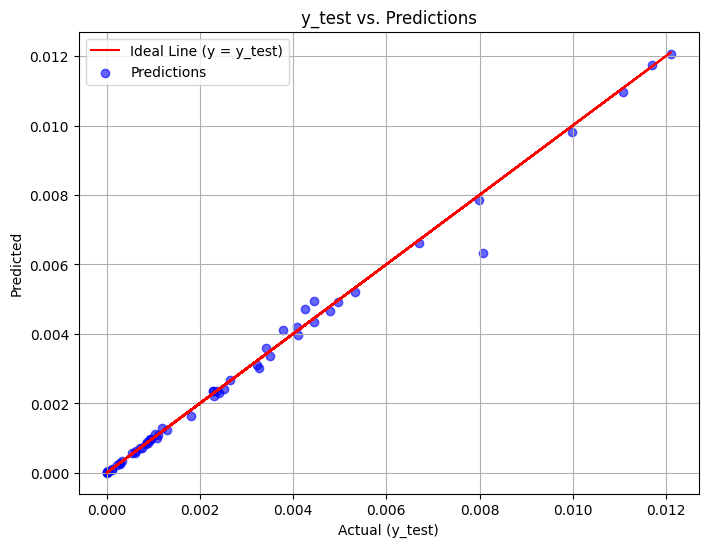

Loaded model from x100_RandomForestRegressor.pkl


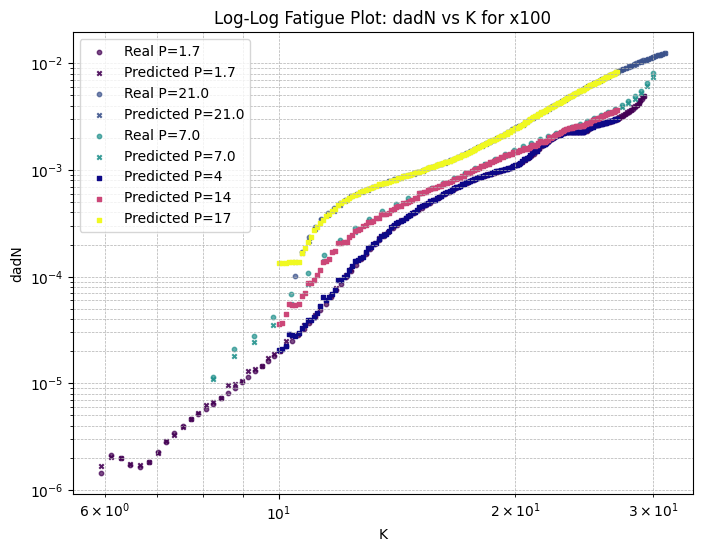

Data saved to x100_prediction_data.csv and x100_predicted_unknown_pressures.csv


In [9]:
dataset = 'x100'
rf(dataset)

# Define K range (start, end, step) and unknown P values
K_range = (10, 27, 0.1)   # Example: K from 7 to 30 with step 0.1
P_unknown = [4,14,17]         # Example: Predict for P = 12
# Generate DataFrame for unknown P
df_pr = unknown_df(K_range, P_unknown)

model_name = 'RandomForestRegressor'
# Example usage:
predict_and_plot(dataset, model_name, df_pr)

Best Parameters: {'model__bootstrap': True, 'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__max_features': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Optimized RF: R² = 0.9879, MAE = 3.920e-05, MSE = 2.600e-09, MAPE = 8.768%, Pearson r = 0.9943


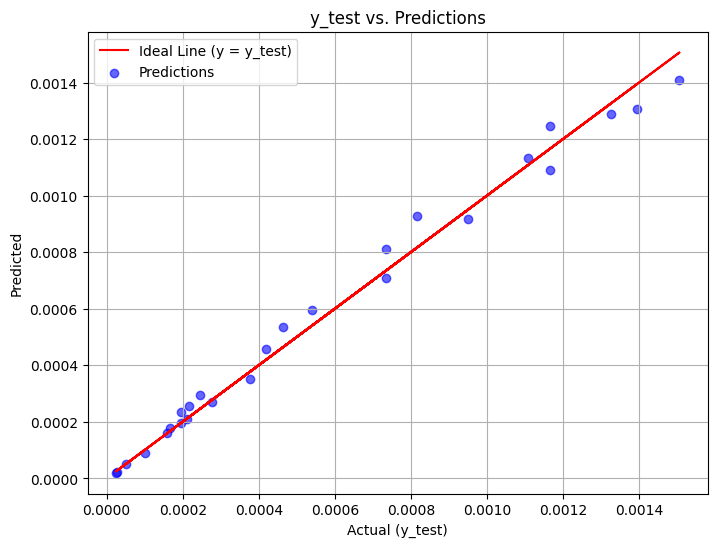

Loaded model from x70_RandomForestRegressor.pkl


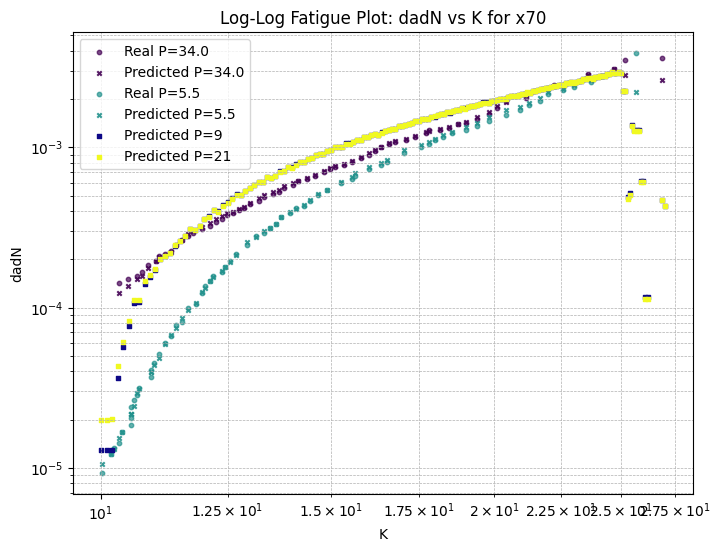

Data saved to x70_prediction_data.csv and x70_predicted_unknown_pressures.csv


In [4]:
dataset = 'x70'
rf(dataset)

# Define K range (start, end, step) and unknown P values
K_range = (10, 27, 0.1)   # Example: K from 7 to 30 with step 0.1
P_unknown = [9,21]         # Example: Predict for P = 12
# Generate DataFrame for unknown P
df_pr = unknown_df(K_range, P_unknown)

model_name = 'RandomForestRegressor'
# Example usage:
predict_and_plot(dataset, model_name, df_pr)

Best Parameters: {'model__bootstrap': True, 'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 90}
Optimized RF: R² = 0.9963, MAE = 1.873e-05, MSE = 1.532e-09, MAPE = 4.399%, Pearson r = 0.9983


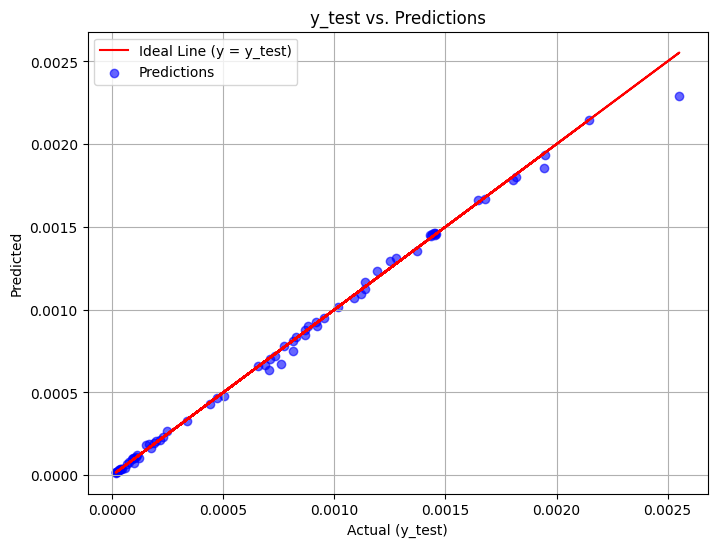

Loaded model from x52_RandomForestRegressor.pkl


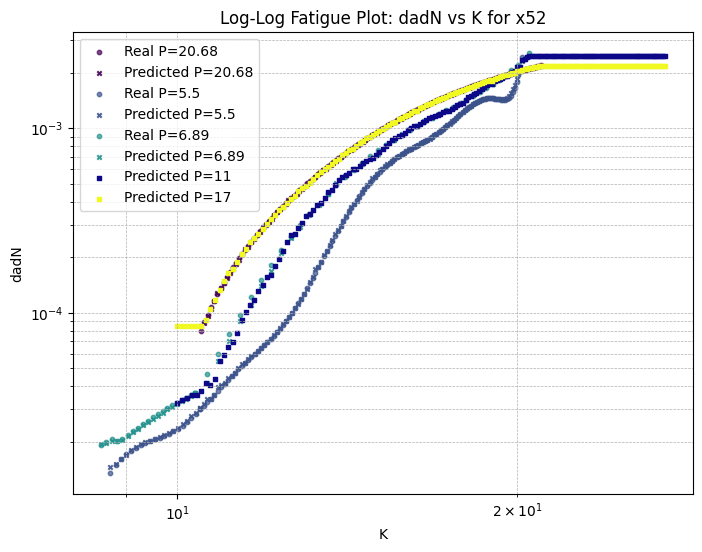

Data saved to x52_prediction_data.csv and x52_predicted_unknown_pressures.csv


In [4]:
dataset = 'x52'
rf(dataset)

# Define K range (start, end, step) and unknown P values
K_range = (10, 27, 0.1)   # Example: K from 7 to 30 with step 0.1
P_unknown = [11,17]         # Example: Predict for P = 12
# Generate DataFrame for unknown P
df_pr = unknown_df(K_range, P_unknown)

model_name = 'RandomForestRegressor'
# Example usage:
predict_and_plot(dataset, model_name, df_pr)